Analyzing Reddit data sentiment using RoBERTa...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Analyzing News data sentiment using FinBERT...


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Combining sentiment data with stock performance data...
Training Random Forest Classifier...
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.53      0.66      0.59        41
    Increase       0.75      0.64      0.69        66

    accuracy                           0.64       107
   macro avg       0.64      0.65      0.64       107
weighted avg       0.67      0.64      0.65       107



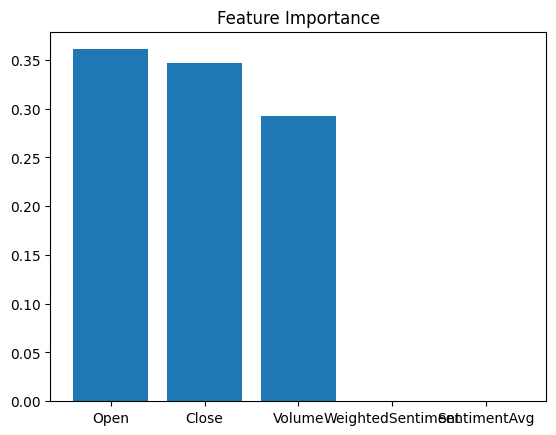

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# Load datasets
reddit_file = '/combined_reddit.csv'
news_file = '/combine_news (1).csv'
stock_file = '/combined_prices.csv'

reddit_data = pd.read_csv(reddit_file)
news_data = pd.read_csv(news_file)
stock_data = pd.read_csv(stock_file)

# Convert date to UNIX timestamp for alignment (if needed)
def date_to_unix(date_str, date_format="%Y-%m-%d %H:%M:%S"):
    try:
        dt = datetime.strptime(date_str, date_format)
        return dt.timestamp()
    except ValueError:
        return None

# Function to analyze sentiment using a BERT model
def analyze_sentiment_bert(model_name, comments):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    sentiments = []
    for comment in comments:
        inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        probabilities = softmax(outputs.logits, dim=-1).detach().numpy()[0]
        sentiment_score = probabilities[2] - probabilities[0]  # Positive - Negative
        sentiments.append(sentiment_score)
    return sentiments

# Sentiment Analysis for Reddit Data (Using RoBERTa)
print("Analyzing Reddit data sentiment using RoBERTa...")
reddit_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
reddit_data['SentimentScore'] = analyze_sentiment_bert(reddit_model_name, reddit_data['comment'])

# Sentiment Analysis for News Data (Using FinBERT)
print("Analyzing News data sentiment using FinBERT...")
news_model_name = "yiyanghkust/finbert-tone"
news_data['SentimentScore'] = analyze_sentiment_bert(news_model_name, news_data['Summary'])

# Combine weighted sentiment scores
reddit_data['WeightedSentiment'] = reddit_data['SentimentScore'] * reddit_data['score']
news_data['WeightedSentiment'] = news_data['SentimentScore']

# Aggregating Reddit sentiment by company
reddit_sentiment = reddit_data.groupby('company').agg(
    WeightedSentimentSum=('WeightedSentiment', 'sum'),
    ScoreSum=('score', 'sum')
).reset_index()

reddit_sentiment['WeightedSentiment'] = reddit_sentiment.apply(
    lambda row: row['WeightedSentimentSum'] / row['ScoreSum'] if row['ScoreSum'] != 0 else 0,
    axis=1
)

# Aggregating News sentiment by company
news_sentiment = news_data.groupby('Company').agg(
    SentimentAvg=('SentimentScore', 'mean')
).reset_index()

# Merging aggregated sentiment with stock data
print("Combining sentiment data with stock performance data...")
merged_data = stock_data.merge(reddit_sentiment[['company', 'WeightedSentiment']], left_on='Company', right_on='company', how='left')
merged_data = merged_data.merge(news_sentiment, on='Company', how='left')
# Preprocessing: Handle numeric conversions and missing values in stock data
def clean_numeric_column(column):
    """Converts a column to numeric by removing commas and handling NaN values."""
    return column.apply(lambda x: float(str(x).replace(",", "")) if pd.notnull(x) else 0)

stock_data['Volume'] = clean_numeric_column(stock_data['Volume'])
stock_data['Open'] = clean_numeric_column(stock_data['Open'])
stock_data['Close'] = clean_numeric_column(stock_data['Close'])

# Merge sentiment data with stock data
merged_data = stock_data.merge(reddit_sentiment[['company', 'WeightedSentiment']], left_on='Company', right_on='company', how='left')
merged_data = merged_data.merge(news_sentiment, on='Company', how='left')

# Handle any remaining NaN values
merged_data[['Open', 'Close', 'Volume', 'WeightedSentiment', 'SentimentAvg']] = merged_data[
    ['Open', 'Close', 'Volume', 'WeightedSentiment', 'SentimentAvg']
].fillna(0)

# Feature Scaling: Standardize stock data features
scaler = StandardScaler()
merged_data[['Open', 'Close', 'Volume']] = scaler.fit_transform(merged_data[['Open', 'Close', 'Volume']])

# Feature Engineering
scaler = StandardScaler()
merged_data[['Open', 'Close', 'Volume']] = scaler.fit_transform(merged_data[['Open', 'Close', 'Volume']])

# Create labels (binary classification: 'Increase' or 'Decrease')
merged_data['Label'] = np.where(merged_data['Close'] > merged_data['Open'], 'Increase', 'Decrease')

# Prepare data for model training
features = merged_data[['Open', 'Close', 'Volume', 'WeightedSentiment', 'SentimentAvg']].fillna(0)
labels = merged_data['Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train and evaluate a model
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize feature importance
importances = clf.feature_importances_
plt.bar(features.columns, importances)
plt.title("Feature Importance")
plt.show()
